# ML Engineer Take Home Project

## Install dependencies

In [40]:
!python -V

Python 3.9.17


In [1]:
!pip install pandas scikit-learn imbalanced-learn lightgbm


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


## Load dataset

In [2]:
dataset_path = "dataset.csv"

In [3]:
import pandas as pd
dataset = pd.read_csv(dataset_path)

In [4]:
dataset

,Received Email? (1=Yes),Date,X1,X2,X3,X4
0,0,2018-07,0,-0.897088,0.804294,0.707665
1,0,2018-09,1,-0.328084,-0.332256,-0.340870
2,0,2015-08,0,1.272140,2.243532,0.815581
3,1,2017-07,1,0.290594,-1.161187,-0.881761
4,0,2018-09,0,-0.307462,1.161276,1.597084
...,...,...,...,...,...,...
5995,1,2017-02,1,-0.650209,-1.861279,-1.565142
5996,0,2015-11,0,0.000512,0.027472,0.669969
5997,1,2017-04,1,0.620417,-0.508042,-0.973381
5998,0,2017-12,0,0.503849,0.893938,0.519877


## Exploration

### Convert column types

In [5]:
dataset.dtypes

Received Email? (1=Yes)      int64
Date                        object
X1                           int64
X2                         float64
X3                         float64
X4                         float64
dtype: object

In [6]:
dataset["Date"] = pd.to_datetime(dataset["Date"])
dataset["Received Email? (1=Yes)"] = dataset["Received Email? (1=Yes)"].astype("bool")
dataset["X1"] = dataset["X1"].astype("bool")

In [7]:
dataset.dtypes

Received Email? (1=Yes)              bool
Date                       datetime64[ns]
X1                                   bool
X2                                float64
X3                                float64
X4                                float64
dtype: object

### EDA

#### Null values

In [8]:
# number of rows with a null value
dataset.isnull().sum(axis=1).sum()

0

#### Dataset balance

In [9]:
dataset["Received Email? (1=Yes)"].value_counts()
# the dataset is highly unbalanced

Received Email? (1=Yes)
False    5066
True      934
Name: count, dtype: int64

#### Features distribution

In [10]:
dataset[dataset["Received Email? (1=Yes)"] == 0][["X1"]].value_counts()

X1   
False    2895
True     2171
Name: count, dtype: int64

In [11]:
dataset[dataset["Received Email? (1=Yes)"] == 1][["X1"]].value_counts()

X1   
True     842
False     92
Name: count, dtype: int64

In [12]:
dataset[["X2", "X3", "X4"]].describe()
# X2-X4 are (roughly) within the same distribution

,X2,X3,X4
count,6000.000000,6000.000000,6000.000000
mean,-0.003326,0.007374,0.015992
std,1.004197,1.012626,1.013181
min,-3.612620,-4.860280,-4.416066
25%,-0.702663,-0.673058,-0.662022
50%,-0.001634,0.015458,0.020163
75%,0.685290,0.681624,0.681972
max,3.896294,3.852129,3.641890


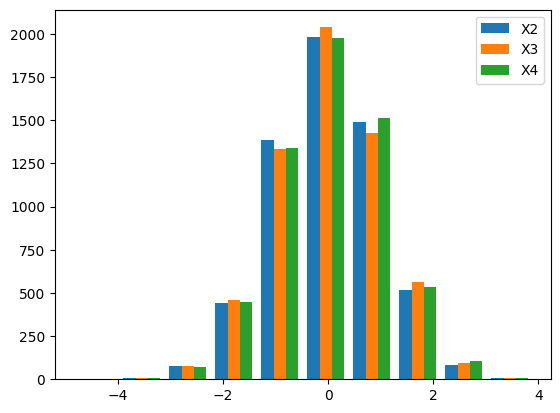

In [13]:
import matplotlib.pyplot as plt

plt.hist(dataset[["X2", "X3", "X4"]], label=["X2", "X3", "X4"])
plt.legend()
plt.show()
# X2-X4 are within the same distribution

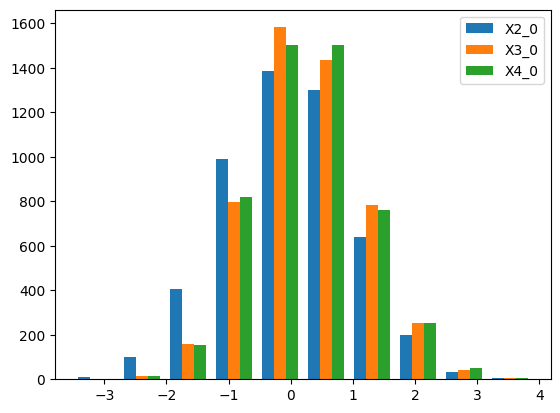

In [14]:
import matplotlib.pyplot as plt

plt.hist(dataset[dataset["Received Email? (1=Yes)"] == 0][["X2", "X3", "X4"]], label=["X2_0", "X3_0", "X4_0"])
plt.legend()
plt.show()
# X2-X4 are within the same distribution for the negative labelled features

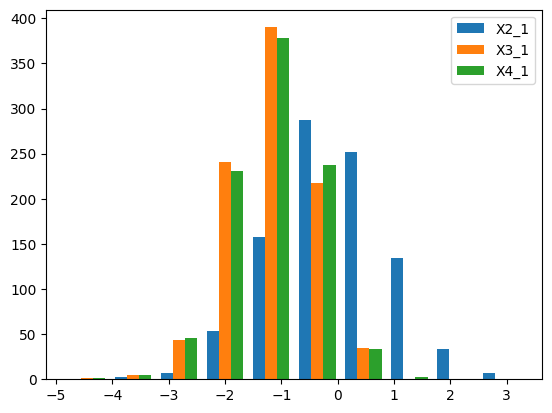

In [15]:
import matplotlib.pyplot as plt

plt.hist(dataset[dataset["Received Email? (1=Yes)"] == 1][["X2", "X3", "X4"]], label=["X2_1", "X3_1", "X4_1"])
plt.legend()
plt.show()
# X2-X4 distribution is more diverse for the positive labelled features

#### Features correlation

In [16]:
def highlight_high_correlations(val):
    """
    Highlights cells with correlation > 0.9 in yellow.
    """
    color = 'yellow' if (val > 0.9 and val < 1) else 'none'
    return f'background-color: {color}'

In [17]:
dataset[["X2", "X3", "X4"]].corr().style.map(highlight_high_correlations)
# X3 and X4 are highly correlated

,X2,X3,X4
X2,1.000000,0.049200,0.050250
X3,0.049200,1.000000,0.901980
X4,0.050250,0.901980,1.000000


#### Outliers

In [18]:
import pandas as pd
import scipy.stats as stats

# Calculate Z-Scores
dataset[["Z2", "Z3", "Z4"]] = dataset[['X2', 'X3', 'X4']].apply(stats.zscore)

# Check for Outliers
outliers_mask = (dataset[["Z2", "Z3", "Z4"]].abs() > 3).any(axis=1)
dataset[~outliers_mask]

,Received Email? (1=Yes),Date,X1,X2,X3,X4,Z2,Z3,Z4
0,False,2018-07-01,False,-0.897088,0.804294,0.707665,-0.890102,0.787049,0.682732
1,False,2018-09-01,True,-0.328084,-0.332256,-0.340870,-0.323428,-0.335423,-0.352249
2,False,2015-08-01,False,1.272140,2.243532,0.815581,1.270241,2.208461,0.789253
3,True,2017-07-01,True,0.290594,-1.161187,-0.881761,0.292716,-1.154087,-0.886147
4,False,2018-09-01,False,-0.307462,1.161276,1.597084,-0.302891,1.139610,1.560653
...,...,...,...,...,...,...,...,...,...
5995,True,2017-02-01,True,-0.650209,-1.861279,-1.565142,-0.644234,-1.845507,-1.560694
5996,False,2015-11-01,False,0.000512,0.027472,0.669969,0.003822,0.019849,0.645523
5997,True,2017-04-01,True,0.620417,-0.508042,-0.973381,0.621188,-0.509032,-0.976583
5998,False,2017-12-01,False,0.503849,0.893938,0.519877,0.505097,0.875583,0.497371


## Feature Engineering

### Dates

Assume that `Date` is the date where the user got the last email and this mode
will predict if the user should get an email again

In [19]:
# Extract year, month and day of week from date as features
dataset["month"] = dataset["Date"].dt.month
dataset["year"] = dataset["Date"].dt.year
dataset["day_of_week"] = dataset["Date"].dt.weekday

In [20]:
from datetime import datetime

# computing the number of days from last received email assuming 2024/01/01 as reference
dataset["days_since_last_email"] = (datetime(year=2024, month=1, day=1) - dataset["Date"]).dt.days

### X_avg

In [21]:
dataset["X_avg"] = dataset[["X2", "X3"]].mean(axis=1)

# we excluded X4 because it is highly correlated with X3

In [22]:
dataset

,Received Email? (1=Yes),Date,X1,X2,X3,X4,Z2,Z3,Z4,month,year,day_of_week,days_since_last_email,X_avg
0,False,2018-07-01,False,-0.897088,0.804294,0.707665,-0.890102,0.787049,0.682732,7,2018,6,2010,-0.046397
1,False,2018-09-01,True,-0.328084,-0.332256,-0.340870,-0.323428,-0.335423,-0.352249,9,2018,5,1948,-0.330170
2,False,2015-08-01,False,1.272140,2.243532,0.815581,1.270241,2.208461,0.789253,8,2015,5,3075,1.757836
3,True,2017-07-01,True,0.290594,-1.161187,-0.881761,0.292716,-1.154087,-0.886147,7,2017,5,2375,-0.435296
4,False,2018-09-01,False,-0.307462,1.161276,1.597084,-0.302891,1.139610,1.560653,9,2018,5,1948,0.426907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,True,2017-02-01,True,-0.650209,-1.861279,-1.565142,-0.644234,-1.845507,-1.560694,2,2017,2,2525,-1.255744
5996,False,2015-11-01,False,0.000512,0.027472,0.669969,0.003822,0.019849,0.645523,11,2015,6,2983,0.013992
5997,True,2017-04-01,True,0.620417,-0.508042,-0.973381,0.621188,-0.509032,-0.976583,4,2017,5,2466,0.056188
5998,False,2017-12-01,False,0.503849,0.893938,0.519877,0.505097,0.875583,0.497371,12,2017,4,2222,0.698894


### Balance dataset

In [23]:
from sklearn.utils.class_weight import compute_class_weight

# Class labels
classes = [0, 1]

# Class weights
class_weights = compute_class_weight('balanced', classes=classes, y=dataset["Received Email? (1=Yes)"])

# Creating a dictionary that can be passed to the model if we don't balance the dataset for ourselves
class_weights_dict = dict(zip(classes, class_weights))
class_weights_dict

{0: 0.5921831819976313, 1: 3.2119914346895073}

In [24]:
# remove X4 because it has high correlation with X3

X = dataset[~outliers_mask][["X1", "X2", "X3", "year", "month", "day_of_week", "days_since_last_email", "X_avg"]]
y = dataset[~outliers_mask]["Received Email? (1=Yes)"]

In [25]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
X_res = X_res.dropna()
y_res = y_res[X_res.index]

## Split dataset

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
# `stratify` will take into account label distribution when splitting the data

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=42, stratify=y_val_and_test)

## Model trials

In [28]:
import numpy as np

def plot_feature_importance(coef, feature_names):
    """Plots the feature importance according to feature coeficients."""
    feature_importances = pd.DataFrame( np.absolute(coef),
                                   index = feature_names,
                                   columns=['importance']).sort_values('importance', ascending=False)
    feature_importances.plot(kind='bar')
    plt.title('Feature Importance')
    plt.show()

### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# max_iter was changed because the default max_iter does not allow convergence
clf = LogisticRegression(random_state=0, max_iter=10_000).fit(X_train, y_train)
y_pred = clf.predict(pd.concat([X_val, X_test]))
report = classification_report(pd.concat([y_val, y_test]), y_pred, digits=3)
print(report)

              precision    recall  f1-score   support

       False      0.885     0.830     0.856      1009
        True      0.840     0.892     0.865      1009

    accuracy                          0.861      2018
   macro avg      0.862     0.861     0.861      2018
weighted avg      0.862     0.861     0.861      2018



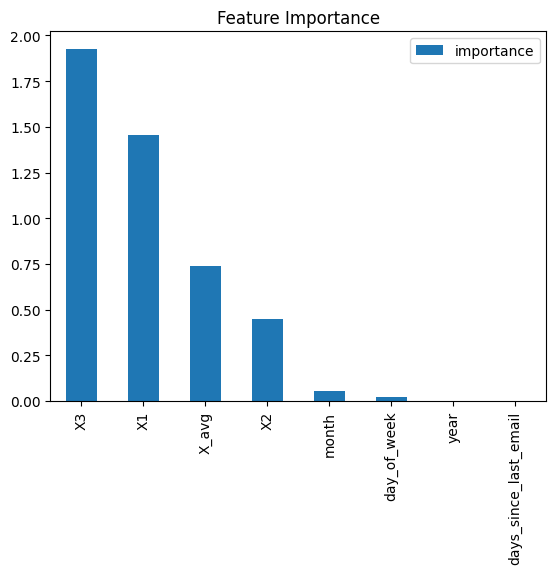

In [30]:
plot_feature_importance(clf.coef_.reshape(-1), clf.feature_names_in_)

### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
y_pred = rf.predict(pd.concat([X_val, X_test]))
report = classification_report(pd.concat([y_val, y_test]), y_pred, digits=3)
print(report)

              precision    recall  f1-score   support

       False      0.922     0.860     0.890      1009
        True      0.869     0.928     0.897      1009

    accuracy                          0.894      2018
   macro avg      0.896     0.894     0.894      2018
weighted avg      0.896     0.894     0.894      2018



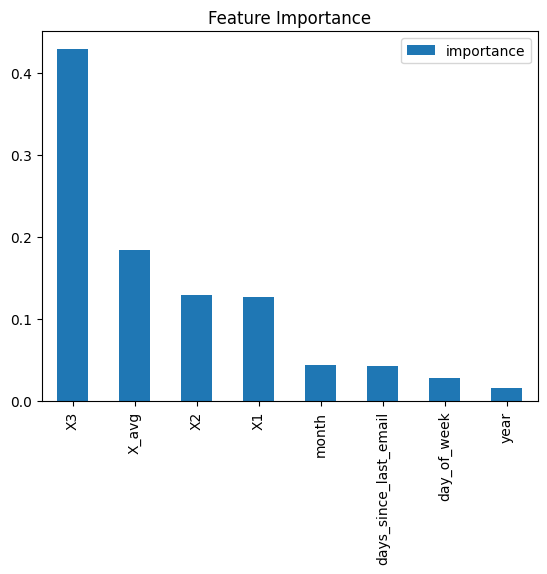

In [32]:
plot_feature_importance(rf.feature_importances_.reshape(-1), rf.feature_names_in_)

### Support Vector Machines

In [33]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Without dual="auto" the model does not converge
svm = LinearSVC(dual="auto", random_state=0).fit(X_train, y_train)
y_pred = svm.predict(X_test)
report = classification_report(y_test, y_pred, digits=3)
print(report)

              precision    recall  f1-score   support

       False      0.883     0.810     0.845       505
        True      0.824     0.893     0.857       504

    accuracy                          0.851      1009
   macro avg      0.854     0.851     0.851      1009
weighted avg      0.854     0.851     0.851      1009



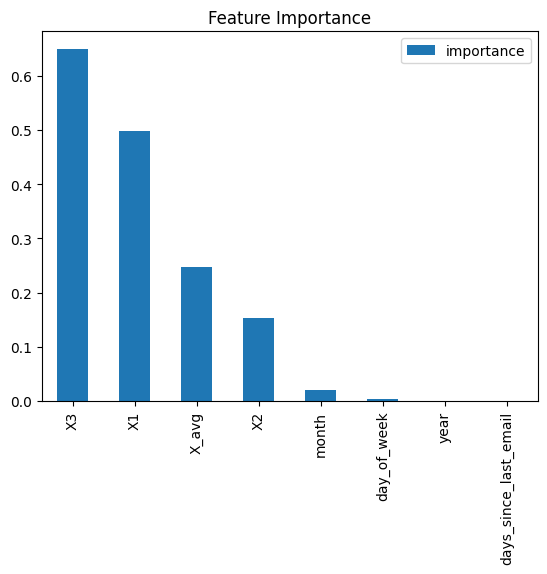

In [34]:
plot_feature_importance(svm.coef_.reshape(-1),svm.feature_names_in_)

### LightGBM

In [35]:
import lightgbm as lgb
from sklearn.metrics import classification_report

In [36]:
train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [37]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
}

lgbm_model = lgb.train(params, train_data, valid_sets=[validation_data], num_boost_round=100)

[LightGBM] [Info] Number of positive: 4035, number of negative: 4035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 8070, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [38]:
y_pred = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)
# Convert probabilities to binary output (0 or 1) if it's a binary classification
y_pred_binary = (y_pred > 0.5).astype(int)
report = classification_report(y_test, y_pred_binary, digits=3)
print(report)

              precision    recall  f1-score   support

       False      0.914     0.846     0.879       505
        True      0.856     0.921     0.887       504

    accuracy                          0.883      1009
   macro avg      0.885     0.883     0.883      1009
weighted avg      0.885     0.883     0.883      1009



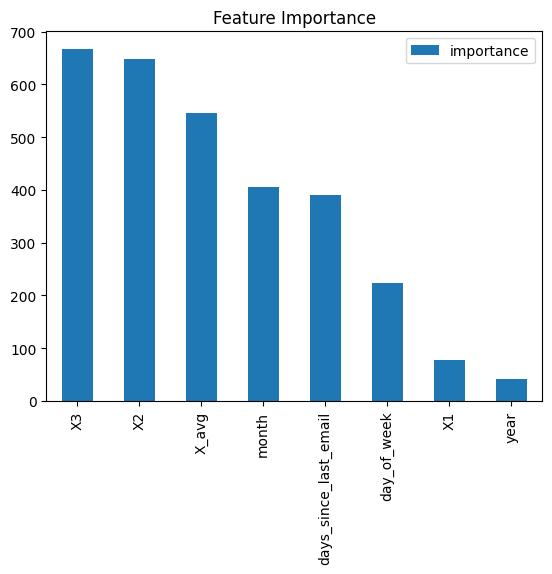

In [39]:
plot_feature_importance(lgbm_model.feature_importance().reshape(-1), lgbm_model.feature_name())